# UPDATED DATASET & CLASSIFICATION METHOD FOR NID

#### Rayen NAIT SLIMANE - Masters Student ISIMA INP

**NOTE:** This notebook is designed to run on [Kaggle](kaggle.com) with the [CICIDS2017-cleaned-and-preprocessed-dataset](https://www.kaggle.com/datasets/ericanacletoribeiro/cicids2017-cleaned-and-preprocessed).

Unlike the previous notebook this one uses cleaned and preprocessed dataset found on Kaggle. The random forest model is trained on 80% of the entire dataset, millions of datapoints. Furthermore SMOTE is used to balance out the dataset and obtain better performance.


## 1. Exploration
### 1.1 Data Loading

In [2]:
!pip install -U scikit-learn imbalanced-learn -q

In [3]:
import pandas as pd
import random

# CSV data file
file = "/kaggle/input/cicids2017-cleaned-and-preprocessed/cicids2017_cleaned.csv"

df = pd.read_csv(file)

In [4]:
# Preview the data frame

print("COLUMN INFO:")
print(df.info())

print("\nATTACK TYPES:")
print(df['Attack Type'].value_counts())

non_benign = len(df) - df['Attack Type'].value_counts()['Normal Traffic']
print(f"\nNON BENIGN COUNT: {non_benign}")


COLUMN INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2520751 entries, 0 to 2520750
Data columns (total 53 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Destination Port             int64  
 1   Flow Duration                int64  
 2   Total Fwd Packets            int64  
 3   Total Length of Fwd Packets  int64  
 4   Fwd Packet Length Max        int64  
 5   Fwd Packet Length Min        int64  
 6   Fwd Packet Length Mean       float64
 7   Fwd Packet Length Std        float64
 8   Bwd Packet Length Max        int64  
 9   Bwd Packet Length Min        int64  
 10  Bwd Packet Length Mean       float64
 11  Bwd Packet Length Std        float64
 12  Flow Bytes/s                 float64
 13  Flow Packets/s               float64
 14  Flow IAT Mean                float64
 15  Flow IAT Std                 float64
 16  Flow IAT Max                 int64  
 17  Flow IAT Min                 int64  
 18  Fwd IAT Total                

### 1.2 Missing Values

In [5]:
# Calculate the total number of rows
total_rows = len(df)

# Calculate the count and percentage of missing values per column
missing_info = pd.DataFrame({
    'Missing Count': df.isnull().sum(),
    'Missing Percentage (%)': (df.isnull().sum() / total_rows) * 100
})

# Filter and display only columns with missing data, sorted by percentage
print(missing_info[missing_info['Missing Count'] > 0].sort_values(by='Missing Percentage (%)', ascending=False))


Empty DataFrame
Columns: [Missing Count, Missing Percentage (%)]
Index: []


### 1.3 Vastly Different Scales

In [6]:
# Display min, max, and std for all numerical features
print(df.describe().T[['min', 'max', 'std']])

                                      min           max           std
Destination Port             0.000000e+00  6.553500e+04  1.901294e+04
Flow Duration               -1.300000e+01  1.200000e+08  3.523140e+07
Total Fwd Packets            1.000000e+00  2.197590e+05  7.943824e+02
Total Length of Fwd Packets  0.000000e+00  1.290000e+07  1.011595e+04
Fwd Packet Length Max        0.000000e+00  2.482000e+04  7.563122e+02
Fwd Packet Length Min        0.000000e+00  2.325000e+03  6.079887e+01
Fwd Packet Length Mean       0.000000e+00  5.940857e+03  1.955512e+02
Fwd Packet Length Std        0.000000e+00  7.125597e+03  2.968824e+02
Bwd Packet Length Max        0.000000e+00  1.953000e+04  2.038152e+03
Bwd Packet Length Min        0.000000e+00  2.896000e+03  7.088017e+01
Bwd Packet Length Mean       0.000000e+00  5.800500e+03  6.325259e+02
Bwd Packet Length Std        0.000000e+00  8.194660e+03  8.810516e+02
Flow Bytes/s                -2.610000e+08  2.071000e+09  2.657109e+07
Flow Packets/s      

### 1.4 Highly Correlated Features

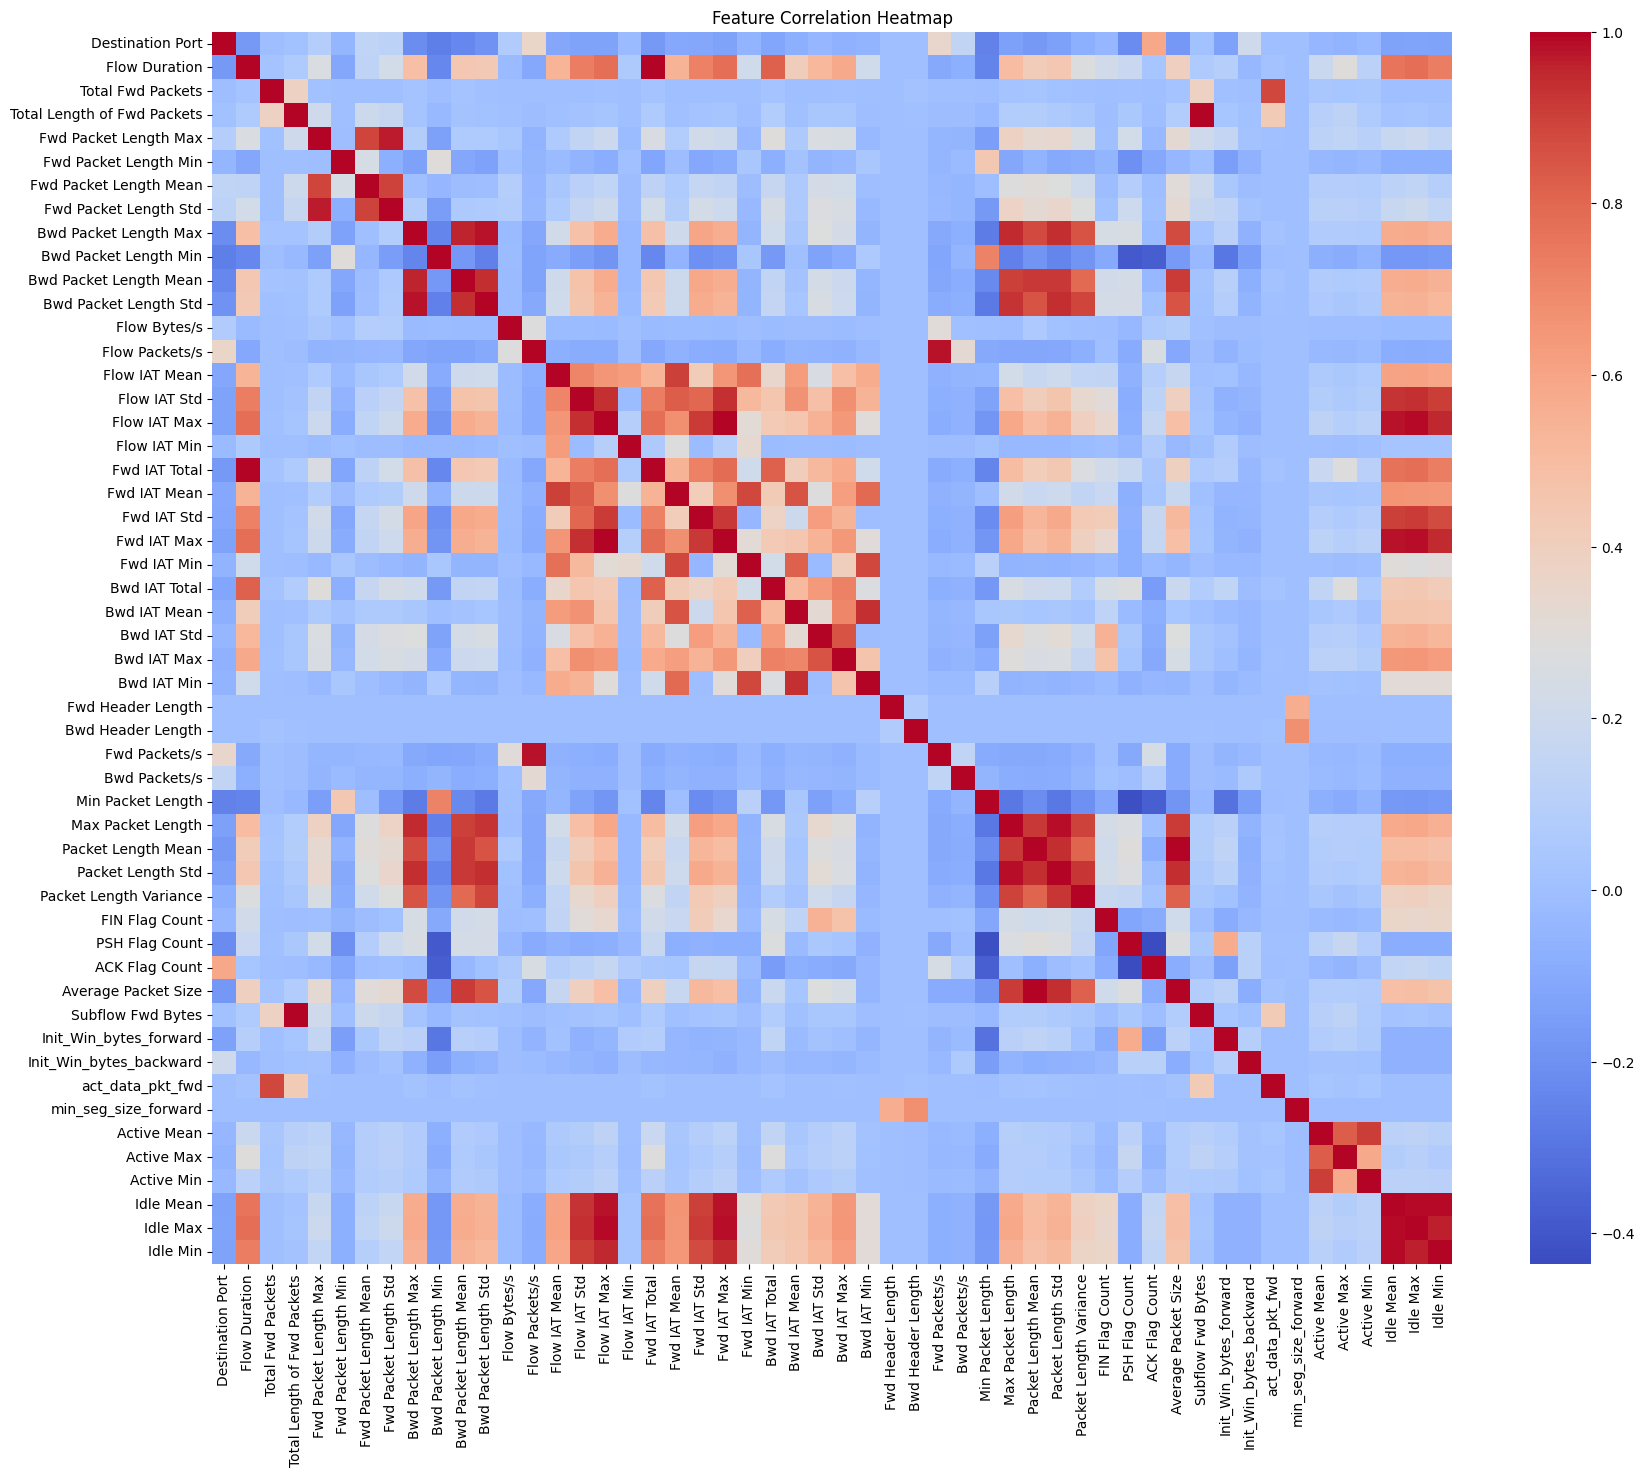

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix for only numerical data
corr_matrix = df.select_dtypes(include=['number']).corr()

plt.figure(figsize=(20, 16))

# Use a heatmap to visualize
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False) 
plt.title('Feature Correlation Heatmap')
plt.show()

## 2. Preprocessing
### 2.2 Split data

In [8]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

y = df['Attack Type']
X = df.drop('Attack Type', axis=1)
X = X.select_dtypes(include=['number'])

le = LabelEncoder()
y = le.fit_transform(y)

# Stratify ensures all classes appear proportionally in both train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 3. Model Architecture & Training

In [9]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Check original distribution
print("Original training distribution:")
print(Counter(y_train))

# Apply SMOTE with conservative strategy
# Boost only the rare classes (Bots and Web Attacks)
smote = SMOTE(
    sampling_strategy={
        0: 10000,   # Bots - adjust based on your label encoding
        6: 5000    # Web Attacks - adjust based on your label encoding
    },
    random_state=42,
    k_neighbors=3
)

X_train_resampled = smote.fit_resample(X_train, y_train)[0]
y_train_resampled = smote.fit_resample(X_train, y_train)[1]

Original training distribution:
Counter({4: 1676045, 3: 154996, 2: 102411, 5: 72555, 1: 7320, 6: 1714, 0: 1559})


In [10]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=50, 
    max_depth=10, 
    random_state=42
)
rf.fit(X_train_resampled, y_train_resampled)  # Use resampled data
y_pred_rf = rf.predict(X_test)

# 5. Results & Evaluation

In [11]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np
import warnings

# Predictions
y_pred_rf = rf.predict(X_test)

# Basic accuracy
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"RF Accuracy: {rf_accuracy:.4f}\n")

# Classification reports with zero_division parameter
print("="*50)
print("RF Classification Report:")
print("="*50)
print(classification_report(y_test, y_pred_rf, target_names=le.classes_, zero_division=0))

# Confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

print("\nRF Confusion Matrix:")
print(cm_rf)

# Optional: Check which classes weren't predicted
print("\n" + "="*50)
print("Prediction Coverage:")
print("="*50)
print(f"Classes in test set: {len(np.unique(y_test))}")
print(f"Classes predicted by RF: {len(np.unique(y_pred_rf))}")

# Show unpredicted classes
unpredicted_rf = set(y_test) - set(y_pred_rf)
if unpredicted_rf:
    print(f"Classes RF failed to predict: {[le.classes_[i] for i in unpredicted_rf]}")

RF Accuracy: 0.9968

RF Classification Report:
                precision    recall  f1-score   support

          Bots       0.58      0.60      0.59       389
   Brute Force       1.00      0.97      0.99      1830
          DDoS       1.00      1.00      1.00     25603
           DoS       1.00      0.98      0.99     38749
Normal Traffic       1.00      1.00      1.00    419012
 Port Scanning       0.99      0.99      0.99     18139
   Web Attacks       0.99      0.84      0.91       429

      accuracy                           1.00    504151
     macro avg       0.94      0.91      0.92    504151
  weighted avg       1.00      1.00      1.00    504151


RF Confusion Matrix:
[[   234      0      0      0    155      0      0]
 [     0   1783      0      0     47      0      0]
 [     0      0  25549      0     54      0      0]
 [     0      0      1  37910    837      0      1]
 [   171      0      2     12 418637    190      0]
 [     0      0      0      9     87  18042      1]


In [12]:
import joblib

filename = 'random-forest-cicids2017.joblib'

# Save the most performant model to disk
joblib.dump(rf, filename)

['random-forest-cicids2017.joblib']